In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import r2_score

import ROOT
from ROOT import TLorentzVector, TVector3

#from eval_model import eval_model, eval_plots
from new_model import *
from DataLoader_Parallel import CustomDataset

import uproot
import awkward as ak
import vector

Welcome to JupyROOT 6.28/06


In [2]:
L_eval_dataset = "WS_L_1M/datasets_fullBoost/dataset_combined.pt"
R_eval_dataset = "WS_R_1M/datasets_fullBoost/dataset_combined.pt"

in_model = "WS_U_10M/training_All_Task_fullBoost_tanh_60epoch_64embed/model_final.torch"

In [3]:
L_dataset = torch.load(L_eval_dataset, weights_only=False)
R_dataset = torch.load(R_eval_dataset, weights_only=False)

model = torch.load(in_model, weights_only=False)

In [4]:
with uproot.open("../pythia/WS_R_1M/combined.root:fastjet") as f:
    quark_energy_R = f["truth_bottom_e_boosted"].array()
    probe_jet_pT_R = f["probe_jet_pT"].array()
    
with uproot.open("../pythia/WS_L_1M/combined.root:fastjet") as f:
    quark_energy_L = f["truth_bottom_e_boosted"].array()
    probe_jet_pT_L = f["probe_jet_pT"].array()

In [5]:
COS_THETA_L = []
for probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels in L_dataset:
    COS_THETA_L.append(direct_labels[1])
COS_THETA_R = []
for probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels in R_dataset:
    COS_THETA_R.append(direct_labels[1])

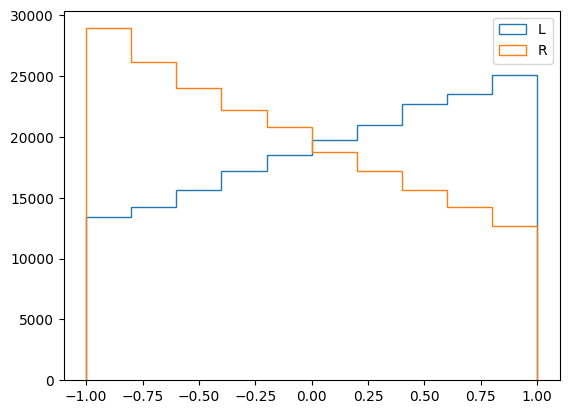

191080
200623


In [6]:
plt.hist(COS_THETA_L,label='L',histtype='step')
plt.hist(COS_THETA_R,label='R',histtype='step')
plt.legend()
plt.show()
print(len(COS_THETA_L))
print(len(COS_THETA_R))

In [7]:
for i, (probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels) in enumerate(R_dataset):
    if i>10:
        break
    print(probe_jet[0][0].float().numpy(), "\t", probe_jet_pT_R[i])   

320.9751 	 320.9751
515.91986 	 515.91986
272.42877 	 272.42877
305.08875 	 305.08875
336.18384 	 336.18384
354.2321 	 354.2321
486.87494 	 486.87494
381.73495 	 381.73495
293.34494 	 293.34494
319.86353 	 319.86353
296.78906 	 296.78906


In [8]:
batch_size=128
L_loader = DataLoader(L_dataset, batch_size=batch_size)
R_loader = DataLoader(R_dataset, batch_size=batch_size)

In [9]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [10]:
def validate_predictions(true, pred, var_names):
    num_feats = len(var_names)
    ranges_dict = {"top_px": (-1000,1000),
                   "top_py": (-1000,1000),
                   "top_pz": (-1000,1000),
                   "top_e" : (0,1500),
                   "down_px": (-1.1,1.1),
                   "down_py": (-1.1,1.1),
                   "down_pz": (-1.1,1.1),
                   "bottom_px": (-1.1,1.1),
                   "bottom_py": (-1.1,1.1),
                   "bottom_pz": (-1.1,1.1),
                   "costheta": (-1.1,1.1)}


    for i ,var in enumerate(var_names):
        var_range = ranges_dict[var]

        plt.figure()
        plt.hist(np.ravel(true[:,i]),histtype='step',color='r',label='True Distribution',bins=50,range=var_range)
        plt.hist(np.ravel(pred[:,i]),histtype='step',color='b',label='Predicted Distribution',bins=50,range=var_range)
        plt.title("Predicted Ouput Distribution using Attention Model")
        plt.legend()
        plt.yscale('log')
        plt.xlabel(var_names[i],loc='right')
        #plt.savefig(dir_training+"/pred_1d_"+var_names[i]+".png")
        plt.show()
        plt.close()

        #plt.figure()
        fig, ax = plt.subplots()
        plt.title("Ouput Distribution using Attention Model")
        h = ax.hist2d(np.ravel(pred[:,i]),np.ravel(true[:,i]), bins=100,norm=mcolors.LogNorm(),range=(var_range,var_range))
        #fig.colorbar(h[3], ax=ax)
        plt.xlabel('Predicted '+var_names[i],loc='right')
        plt.ylabel('True '+var_names[i],loc='top')
        diff = var_range[1] - var_range[0]
        plt.text(var_range[1]-0.3*diff,var_range[0]+0.2*diff,"$R^2$ value: "+str(round(r2_score(np.ravel(true[:,i]),np.ravel(pred[:,i])),3)),backgroundcolor='r',color='k')
        #print("R^2 value: ", round(r2_score(true_labels[:,i],predicted_labels[:,i]),3))
        #plt.savefig(dir_training+"/pred_2d_"+var_names[i]+".png")
        plt.show()
        plt.close()

In [11]:
top_feats=4
pred_top_L = np.array([]).reshape(0,top_feats)
true_top_L = np.array([]).reshape(0,top_feats)

down_feats=3
pred_down_L = np.array([]).reshape(0,down_feats)
true_down_L = np.array([]).reshape(0,down_feats)

direct_feats=1
pred_direct_L = np.array([]).reshape(0,direct_feats)
true_direct_L = np.array([]).reshape(0,direct_feats)

for probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels in L_loader:
    top_pred, down_pred, direct_pred, track_pred = model(probe_jet.to(device), constituents.to(device), event.to(device))

    #down_pred = torch.tanh(down_pred)
    
    pred_top_L = np.vstack((pred_top_L,top_pred.detach().cpu().numpy()))
    true_top_L = np.vstack((true_top_L,top_labels.detach().cpu().numpy()))

    pred_down_L = np.vstack((pred_down_L,down_pred.detach().cpu().numpy()))
    true_down_L = np.vstack((true_down_L,bottom_labels.detach().cpu().numpy()))

    pred_direct_L = np.vstack((pred_direct_L,direct_pred.detach().cpu().numpy()))
    true_direct_L = np.vstack((true_direct_L,direct_labels[:,1].reshape(-1,1).detach().cpu().numpy()))

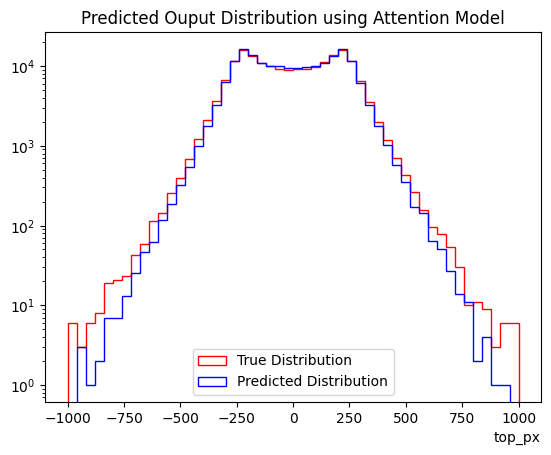

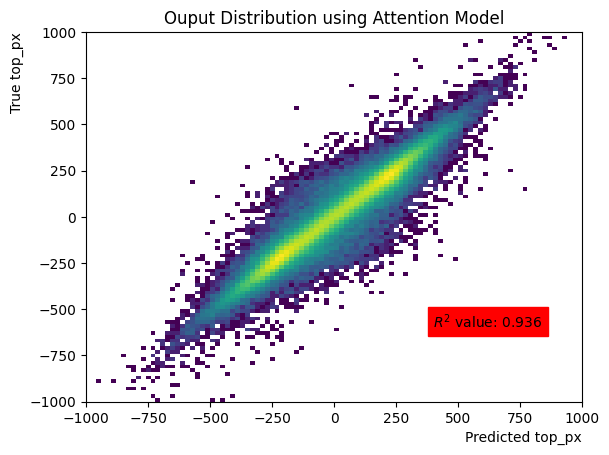

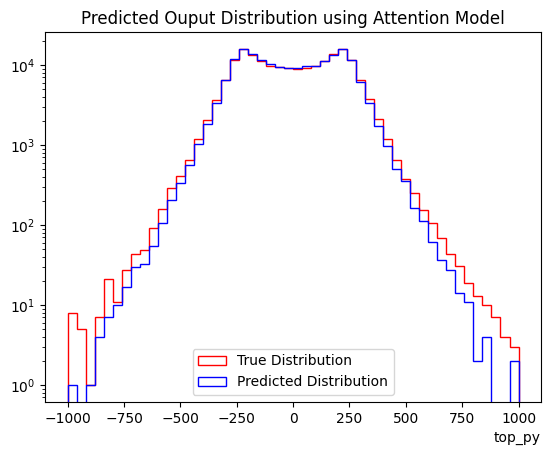

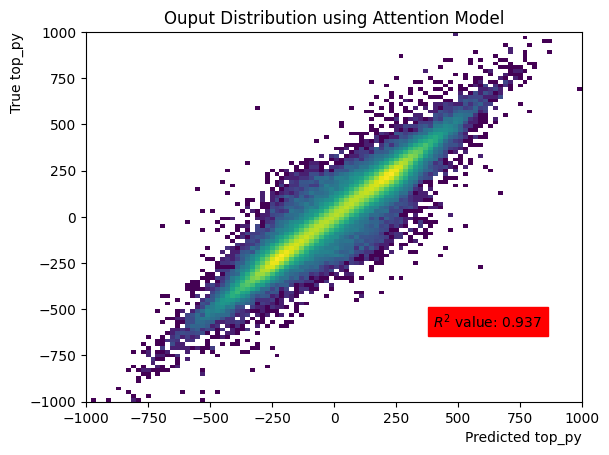

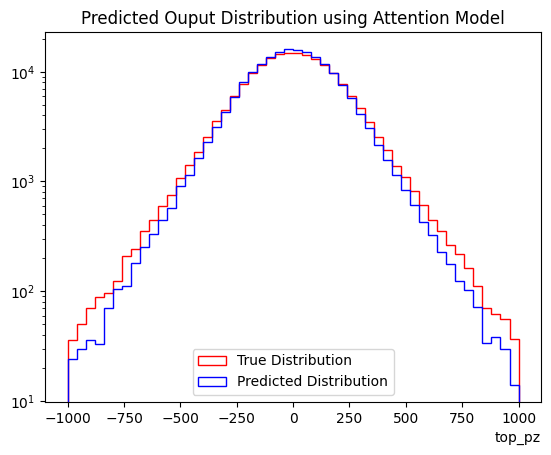

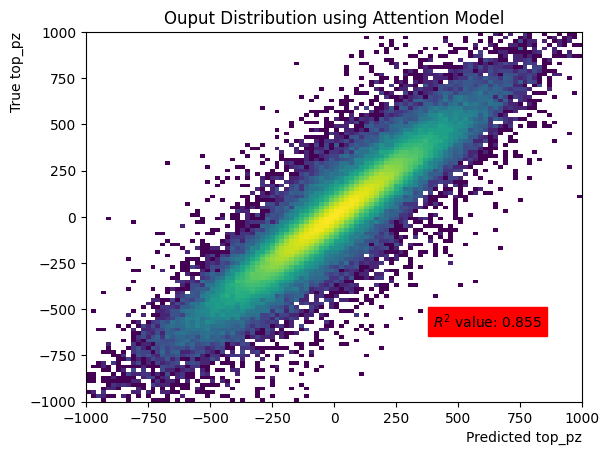

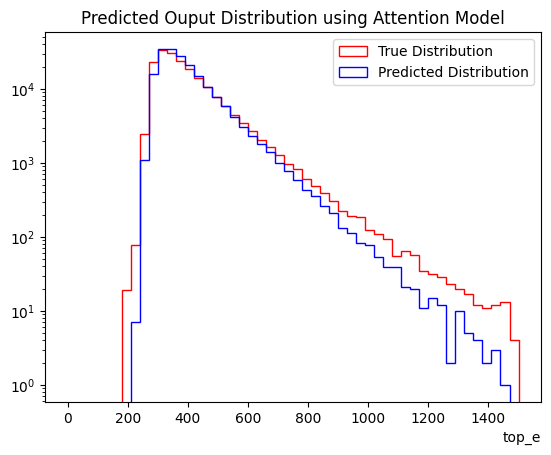

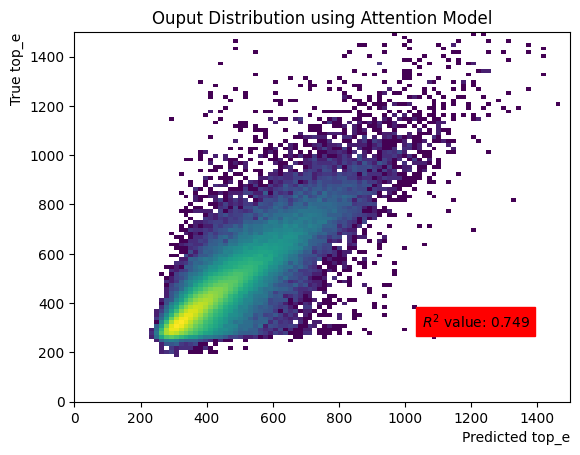

In [12]:
do_PlotTop=True
if do_PlotTop:
    validate_predictions(true_top_L, pred_top_L, ["top_px", "top_py", "top_pz", "top_e"])

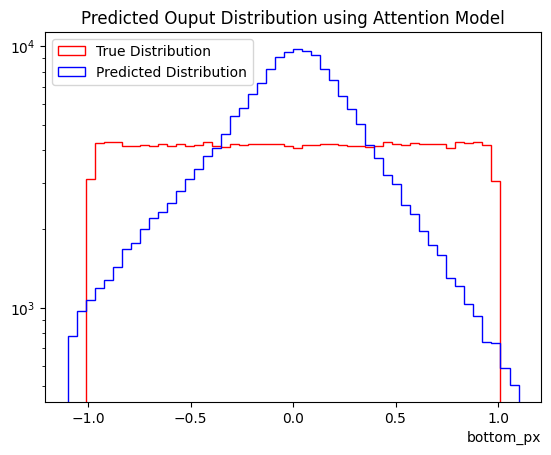

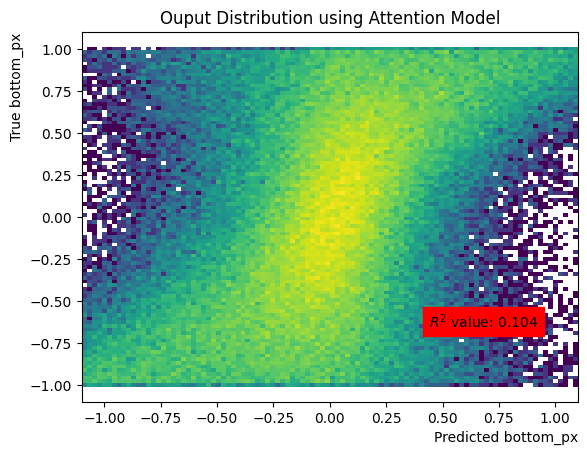

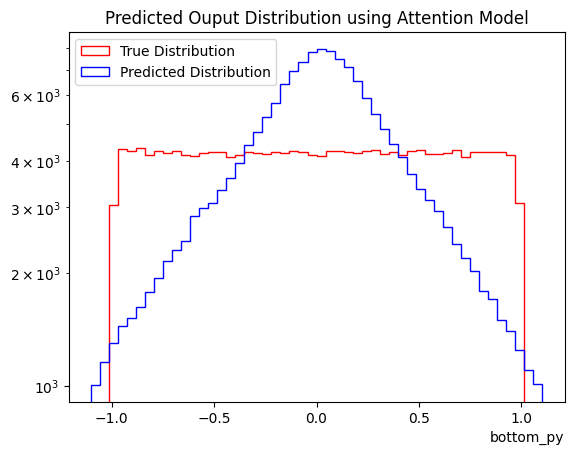

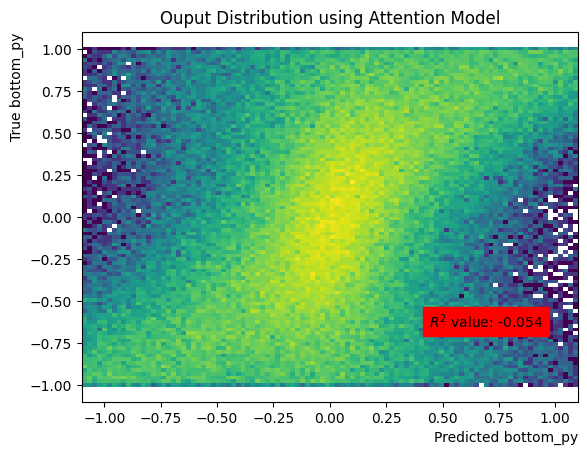

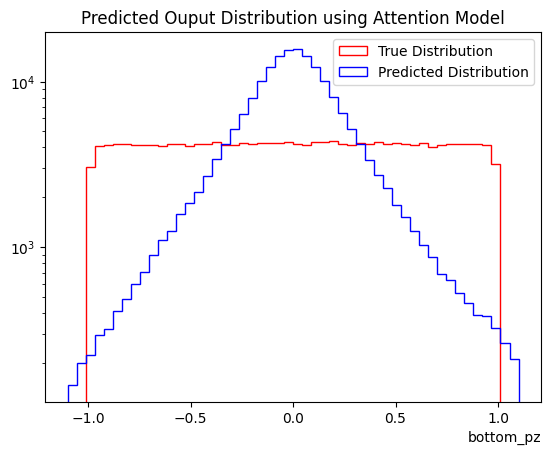

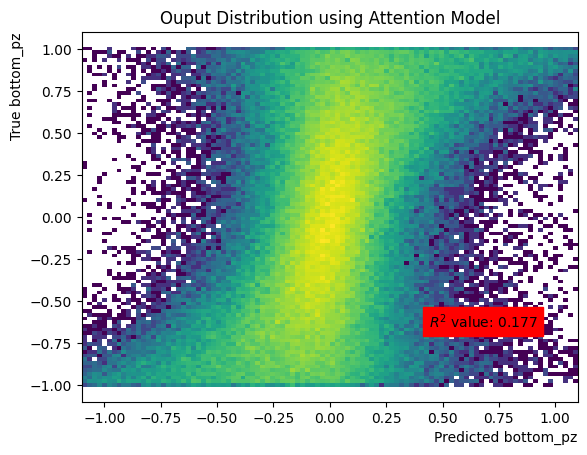

In [13]:
do_PlotDown=True
if do_PlotDown:
    validate_predictions(true_down_L, pred_down_L, ["bottom_px", "bottom_py", "bottom_pz"])

In [14]:
top_feats=4
pred_top_R = np.array([]).reshape(0,top_feats)
true_top_R = np.array([]).reshape(0,top_feats)

down_feats=3
pred_down_R = np.array([]).reshape(0,down_feats)
true_down_R = np.array([]).reshape(0,down_feats)

direct_feats=1
pred_direct_R = np.array([]).reshape(0,direct_feats)
true_direct_R = np.array([]).reshape(0,direct_feats)

for probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels in R_loader:
    top_pred, down_pred, direct_pred, track_pred = model(probe_jet.to(device), constituents.to(device), event.to(device))

    down_pred = torch.tanh(down_pred)
    
    pred_top_R = np.vstack((pred_top_R,top_pred.detach().cpu().numpy()))
    true_top_R = np.vstack((true_top_R,top_labels.detach().cpu().numpy()))

    pred_down_R = np.vstack((pred_down_R,down_pred.detach().cpu().numpy()))
    true_down_R = np.vstack((true_down_R,bottom_labels.detach().cpu().numpy()))

    pred_direct_R = np.vstack((pred_direct_R,direct_pred.detach().cpu().numpy()))
    true_direct_R = np.vstack((true_direct_R,direct_labels[:,1].reshape(-1,1).detach().cpu().numpy()))

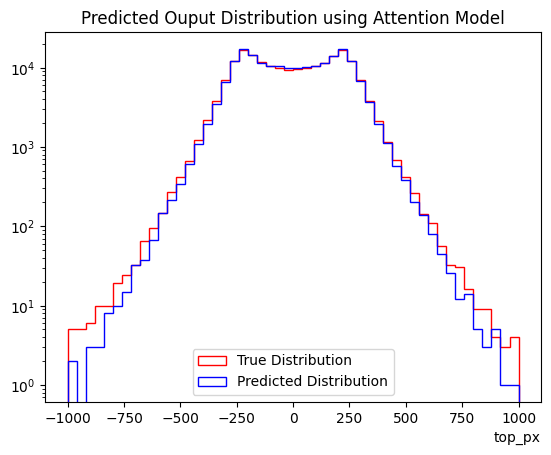

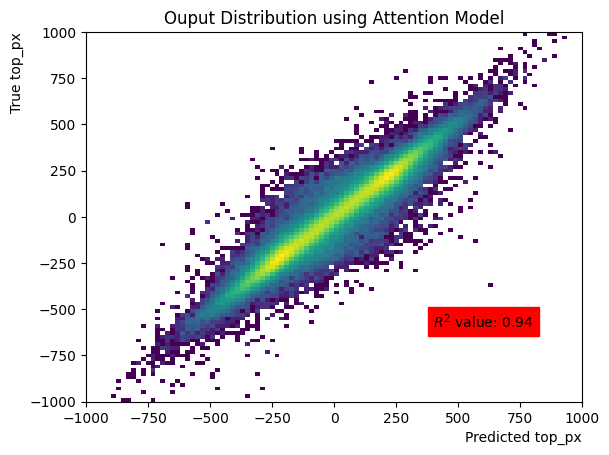

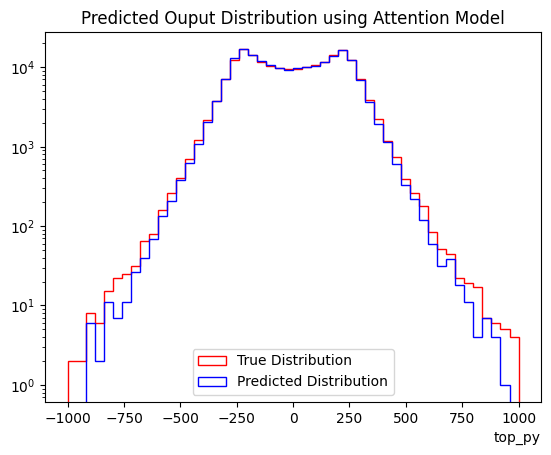

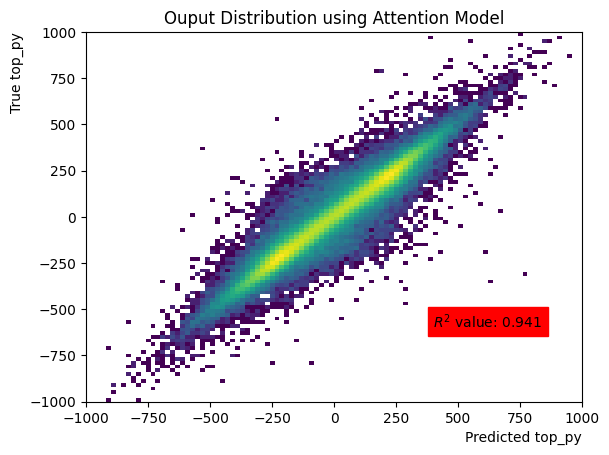

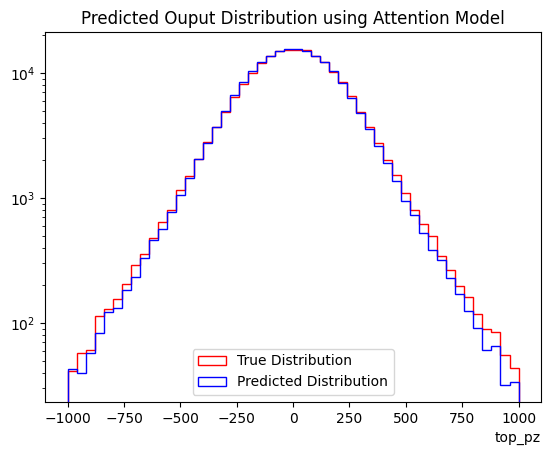

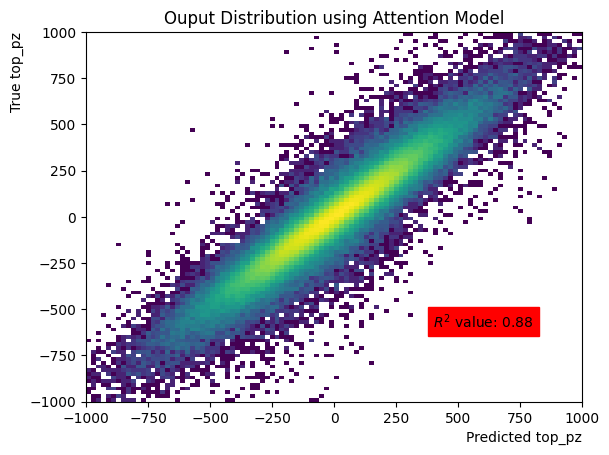

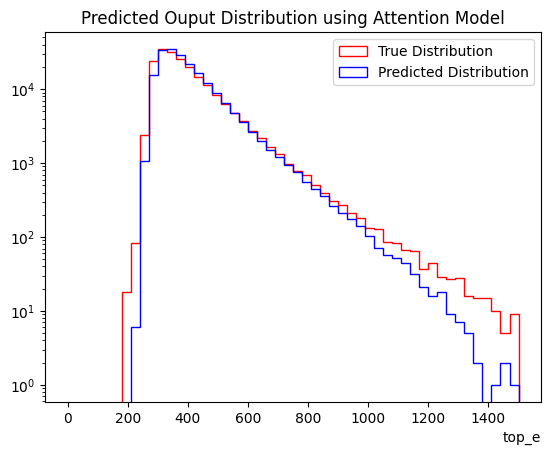

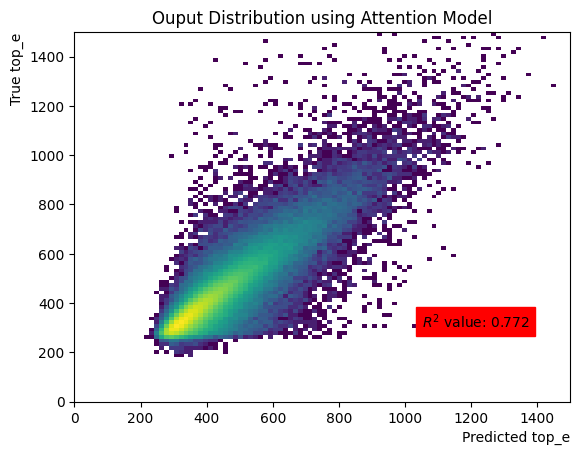

In [15]:
do_PlotTop=True
if do_PlotTop:
    validate_predictions(true_top_R, pred_top_R, ["top_px", "top_py", "top_pz", "top_e"])

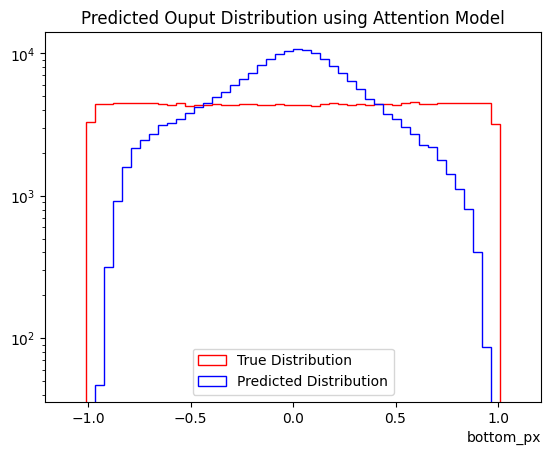

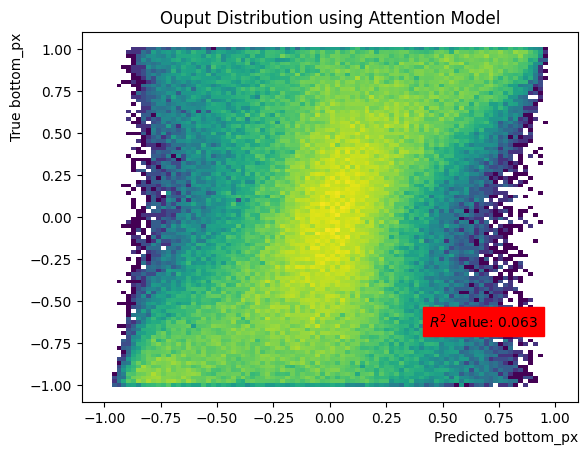

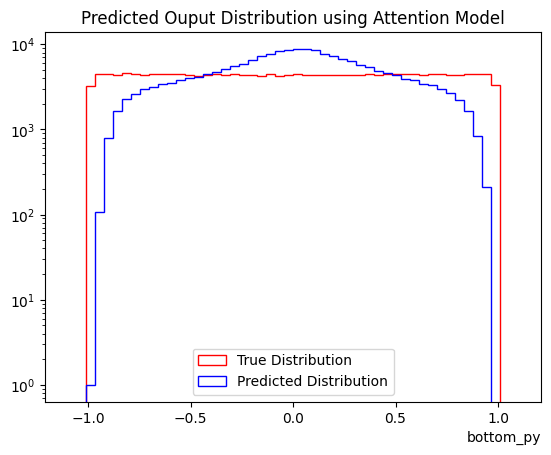

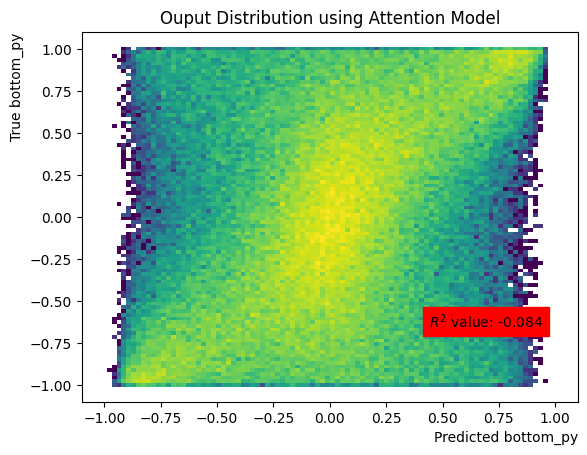

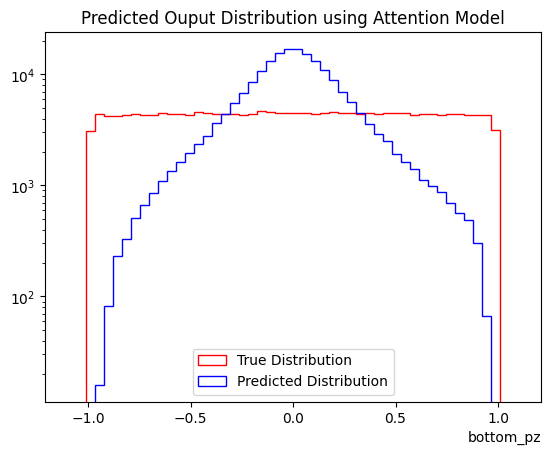

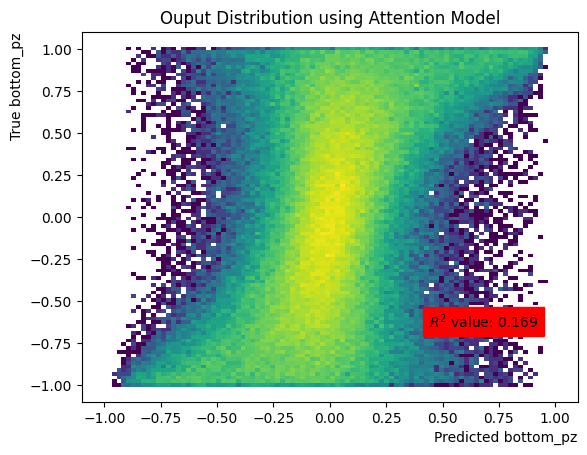

In [16]:
do_PlotDown=True
if do_PlotDown:
    validate_predictions(true_down_R, pred_down_R, ["bottom_px", "bottom_py", "bottom_pz"])

In [17]:
"""
cos_theta_true_L=[]
cos_theta_pred_L=[]

cos_similarity_L=[]

events = len(true_top_L)
for event in range(events):
    vec_top_true_L = TLorentzVector(true_top_L[event,0],true_top_L[event,1],true_top_L[event,2],true_top_L[event,3])
    vec_top_pred_L = TLorentzVector(pred_top_L[event,0],pred_top_L[event,1],pred_top_L[event,2],pred_top_L[event,3])
    vec_down_true_L = TVector3(true_down_L[event,0],true_down_L[event,1],true_down_L[event,2])
    vec_down_pred_L = TVector3(pred_down_L[event,0],pred_down_L[event,1],pred_down_L[event,2])
    
    vec_top_true_L = vec_top_true_L.Vect().Unit()
    vec_top_pred_L = vec_top_pred_L.Vect().Unit()
    
    cos_similarity_L.append(vec_down_true_L.Unit().Dot(vec_down_pred_L.Unit()))

    cos_theta_true_L.append(vec_top_true_L.Dot(vec_down_true_L))
    if post_norm:
        cos_theta_pred_L.append(vec_top_pred_L.Dot(vec_down_pred_L.Unit()))
    else:
        cos_theta_pred_L.append(vec_top_pred_L.Dot(vec_down_pred_L))
"""

'\ncos_theta_true_L=[]\ncos_theta_pred_L=[]\n\ncos_similarity_L=[]\n\nevents = len(true_top_L)\nfor event in range(events):\n    vec_top_true_L = TLorentzVector(true_top_L[event,0],true_top_L[event,1],true_top_L[event,2],true_top_L[event,3])\n    vec_top_pred_L = TLorentzVector(pred_top_L[event,0],pred_top_L[event,1],pred_top_L[event,2],pred_top_L[event,3])\n    vec_down_true_L = TVector3(true_down_L[event,0],true_down_L[event,1],true_down_L[event,2])\n    vec_down_pred_L = TVector3(pred_down_L[event,0],pred_down_L[event,1],pred_down_L[event,2])\n    \n    vec_top_true_L = vec_top_true_L.Vect().Unit()\n    vec_top_pred_L = vec_top_pred_L.Vect().Unit()\n    \n    cos_similarity_L.append(vec_down_true_L.Unit().Dot(vec_down_pred_L.Unit()))\n\n    cos_theta_true_L.append(vec_top_true_L.Dot(vec_down_true_L))\n    if post_norm:\n        cos_theta_pred_L.append(vec_top_pred_L.Dot(vec_down_pred_L.Unit()))\n    else:\n        cos_theta_pred_L.append(vec_top_pred_L.Dot(vec_down_pred_L))\n'

In [18]:
def get_results(true_top, pred_top, true_quark, pred_quark, SF, apply_norm=True):
    cos_theta_true=[]
    cos_theta_pred=[]
    cos_similarity_top=[]
    cos_similarity_quark=[]

    events = len(true_top)
    for event in range(events):
        # Initiliaze 4-Vector for Top
        vec_top_true = TLorentzVector()
        vec_top_true.SetPxPyPzE(true_top[event,0],true_top[event,1],true_top[event,2],true_top[event,3])
        vec_top_pred = TLorentzVector()
        vec_top_pred.SetPxPyPzE(pred_top[event,0],pred_top[event,1],pred_top[event,2],pred_top[event,3])

        # Initialize 4-Vector for sub-quark
        #vec3_quark_true = TVector3(true_quark[event,0]*SF[event],true_quark[event,1]*SF[event],true_quark[event,2]*SF[event])
        #vec3_quark_pred = TVector3(pred_quark[event,0],pred_quark[event,1],pred_quark[event,2]).Unit()
        #vec3_quark_pred = TVector3(vec3_quark_pred.Px(),vec3_quark_pred.Py(),vec3_quark_pred.Pz())
        vec3_quark_true = TVector3(true_quark[event,0],true_quark[event,1],true_quark[event,2])
        vec3_quark_pred = TVector3(pred_quark[event,0],pred_quark[event,1],pred_quark[event,2]).Unit()
        
        vec_quark_true = TLorentzVector()
        #vec_quark_true.SetPtEtaPhiE(vec3_quark_true.Pt(),vec3_quark_true.Eta(),vec3_quark_true.Phi(),SF[event])
        vec_quark_true.SetPtEtaPhiM(vec3_quark_true.Pt(),vec3_quark_true.Eta(),vec3_quark_true.Phi(),0.0)
        vec_quark_pred = TLorentzVector()
        vec_quark_pred.SetPtEtaPhiM(vec3_quark_pred.Pt(),vec3_quark_pred.Eta(),vec3_quark_pred.Phi(),0.0)

        # Calculate boost vector for top rest frame
        to_t_rest_true = -vec_top_true.BoostVector()
        to_t_rest_pred = -vec_top_pred.BoostVector()

        # Boost sub-quark to top rest frame
        #vec_quark_true.Boost(to_t_rest_true)
        #vec_quark_pred.Boost(to_t_rest_pred)
        
        # Unit vector for sub-quark
        d_vect_true = vec_quark_true.Vect().Unit()
        #d_vect_pred = vec_quark_pred.Vect().Unit()
        d_vect_pred = vec3_quark_pred

        
        # Unit vector for top quark
        k_vect_true = vec_top_true.Vect().Unit()
        k_vect_pred = vec_top_pred.Vect().Unit()

        # Calc cos theta and cos sim
        cos_similarity_top.append(k_vect_true.Dot(k_vect_pred))
        cos_similarity_quark.append(d_vect_true.Dot(d_vect_pred))

        cos_theta_true.append(k_vect_true.Dot(d_vect_true))
        cos_theta_pred.append(k_vect_pred.Dot(d_vect_pred))
            
    return np.array(cos_theta_true), np.array(cos_theta_pred), np.array(cos_similarity_top), np.array(cos_similarity_quark)

In [19]:
cos_theta_true_L, cos_theta_pred_L, cos_similarity_top_L, cos_similarity_quark_L = get_results(true_top_L, pred_top_L, true_down_L, pred_down_L, quark_energy_L)

In [20]:
cos_theta_true_R, cos_theta_pred_R, cos_similarity_top_R, cos_similarity_quark_R = get_results(true_top_R, pred_top_R, true_down_R, pred_down_R, quark_energy_R)

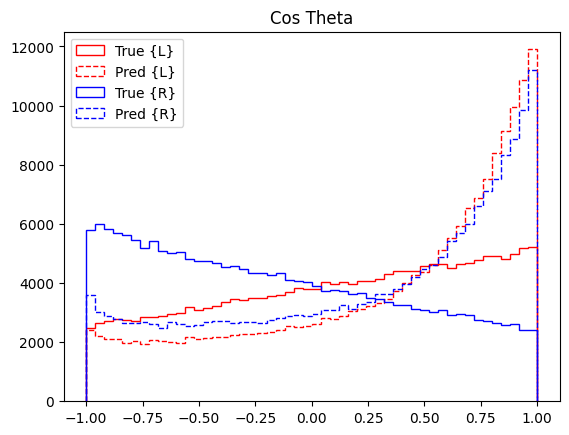

In [21]:
plt.title("Cos Theta")
plt.hist(cos_theta_true_L,histtype='step',bins=50,range=(-1,1),color='r',label='True {L}',linestyle="-")
plt.hist(cos_theta_pred_L,histtype='step',bins=50,range=(-1,1),color='r',label='Pred {L}',linestyle="--")
plt.hist(cos_theta_true_R,histtype='step',bins=50,range=(-1,1),color='b',label='True {R}',linestyle="-")
plt.hist(cos_theta_pred_R,histtype='step',bins=50,range=(-1,1),color='b',label='Pred {R}',linestyle="--")
plt.legend()
plt.show()

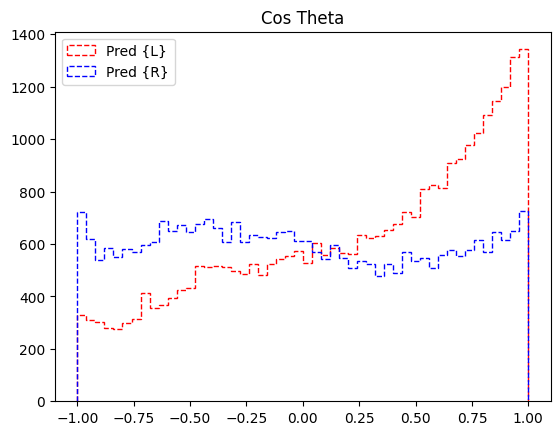

In [22]:
cos_theta_pred_R_good = cos_theta_pred_R[cos_similarity_quark_R>0.95]
cos_theta_pred_L_good = cos_theta_pred_L[cos_similarity_quark_L>0.95]
plt.title("Cos Theta")
plt.hist(cos_theta_pred_L_good,histtype='step',bins=50,range=(-1,1),color='r',label='Pred {L}',linestyle="--")
plt.hist(cos_theta_pred_R_good,histtype='step',bins=50,range=(-1,1),color='b',label='Pred {R}',linestyle="--")
plt.legend()
plt.show()

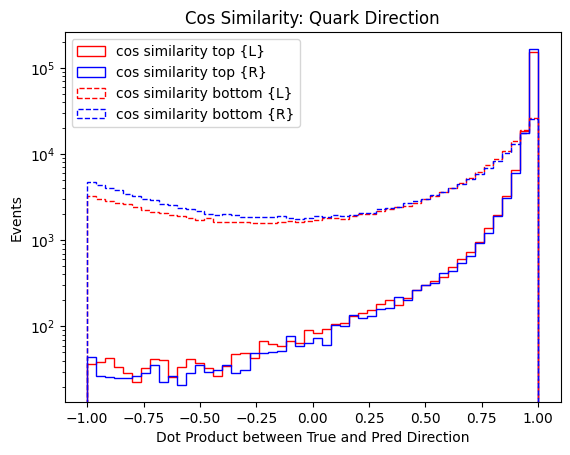

In [23]:
plt.title("Cos Similarity: Quark Direction")
plt.hist(cos_similarity_top_L,histtype='step',bins=50,range=(-1,1),color='r',label='cos similarity top {L}',linestyle="-")
plt.hist(cos_similarity_top_R,histtype='step',bins=50,range=(-1,1),color='b',label='cos similarity top {R}',linestyle="-")
plt.hist(cos_similarity_quark_L,histtype='step',bins=50,range=(-1,1),color='r',label='cos similarity bottom {L}',linestyle="--")
plt.hist(cos_similarity_quark_R,histtype='step',bins=50,range=(-1,1),color='b',label='cos similarity bottom {R}',linestyle="--")
plt.yscale('log')
plt.xlabel("Dot Product between True and Pred Direction")
plt.ylabel("Events")
plt.legend()
plt.show()

In [24]:
with open("results.root", "wb") as file:
    pickle.dump({"cos_theta_true_L": np.array(cos_theta_true_L), 
                       "cos_theta_pred_L": np.array(cos_theta_pred_L),
                       "cos_theta_true_R": np.array(cos_theta_true_R),
                       "cos_theta_pred_R": np.array(cos_theta_pred_R),
                      }, file)

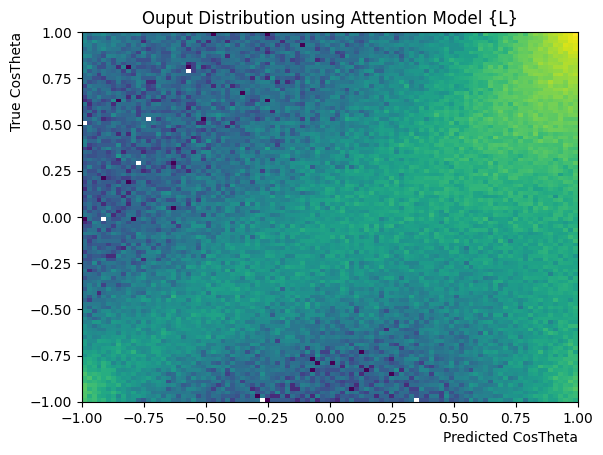

In [25]:
plt.figure()
plt.title("Ouput Distribution using Attention Model {L}")
plt.hist2d(np.array(cos_theta_pred_L),np.array(cos_theta_true_L),bins=100,norm=mcolors.LogNorm(),range=((-1,1),(-1,1)))
plt.xlabel('Predicted CosTheta',loc='right')
plt.ylabel('True CosTheta',loc='top')
#plt.text(1-0.3*2,1-0.8*2,"$R^2$ value: "+str(round(r2_score(np.ravel(cos_theta_pred_L),np.ravel(cos_theta_true_L)),3)),backgroundcolor='r',color='k')
#print("R^2 value: ", round(r2_score(cos_theta_pred_L,cos_theta_true_L),3))
#plt.savefig(out_dir+"/pred_2d_"+feats[i]+".png")
plt.show()
plt.close()

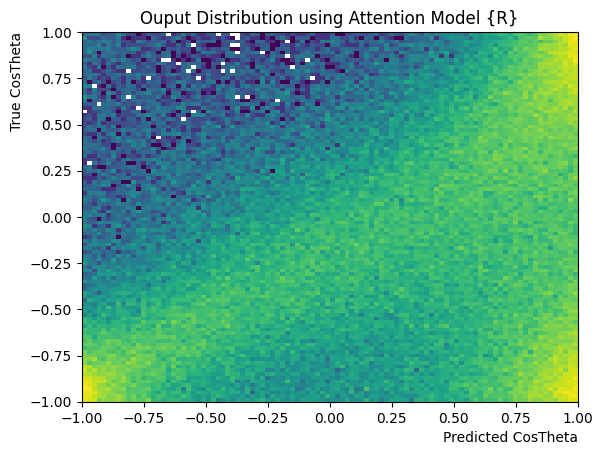

In [26]:
plt.figure()
plt.title("Ouput Distribution using Attention Model {R}")
plt.hist2d(np.array(cos_theta_pred_R),np.array(cos_theta_true_R),bins=100,norm=mcolors.LogNorm(),range=((-1,1),(-1,1)))
plt.xlabel('Predicted CosTheta',loc='right')
plt.ylabel('True CosTheta',loc='top')
#plt.text(1-0.3*2,1-0.8*2,"$R^2$ value: "+str(round(r2_score(np.ravel(cos_theta_pred_R),np.ravel(cos_theta_true_R)),3)),backgroundcolor='r',color='k')
#print("R^2 value: ", round(r2_score(cos_theta_pred_R,cos_theta_true_R),3))
#plt.savefig(out_dir+"/pred_2d_"+feats[i]+".png")
plt.show()
plt.close()

In [27]:
norm_true = np.sqrt(true_down_L[:,0]**2+true_down_L[:,1]**2+true_down_L[:,2]**2)
norm_pred = np.sqrt(pred_down_L[:,0]**2+pred_down_L[:,1]**2+pred_down_L[:,2]**2)

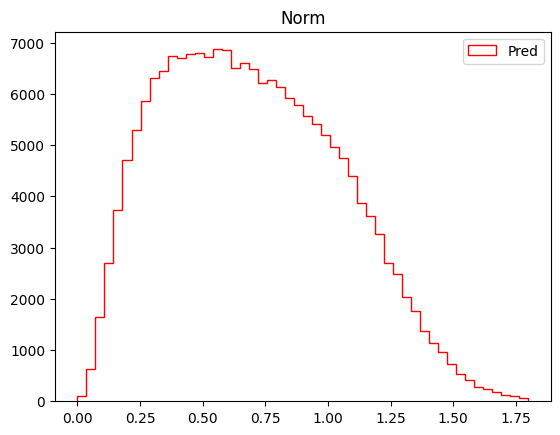

Mean:  0.6988568472946295
Std dev:  0.3498377115185925


In [28]:
plt.title("Norm")
#plt.hist(norm_true,histtype='step',bins=50,range=(0,1.4),color='k',label='True')
plt.hist(norm_pred,histtype='step',bins=50,range=(0,1.8),color='r',label='Pred')
plt.legend()
plt.show()
print("Mean: ", np.mean(norm_pred))
print("Std dev: ", np.std(norm_pred))

In [29]:
output = {
    "true_top_px_R": [],
    "true_top_py_R": [],
    "true_top_pz_R": [],
    
    "pred_top_px_R": [],
    "pred_top_py_R": [],
    "pred_top_pz_R": [],
    
    "true_down_px_R": [],
    "true_down_py_R": [],
    "true_down_pz_R": [],
    
    "pred_down_px_R": [],
    "pred_down_py_R": [],
    "pred_down_pz_R": [],
    
    "true_top_px_L": [],
    "true_top_py_L": [],
    "true_top_pz_L": [],
    
    "pred_top_px_L": [],
    "pred_top_py_L": [],
    "pred_top_pz_L": [],
    
    "true_down_px_L": [],
    "true_down_py_L": [],
    "true_down_pz_L": [],
    
    "pred_down_px_L": [],
    "pred_down_py_L": [],
    "pred_down_pz_L": [],
}

In [30]:
events = len(true_top_R)
for event in range(events):
    output["true_top_px_R"].append(true_top_R[event,0])
    output["true_top_py_R"].append(true_top_R[event,1])
    output["true_top_pz_R"].append(true_top_R[event,2])
    
    output["pred_top_px_R"].append(pred_top_R[event,0])
    output["pred_top_py_R"].append(pred_top_R[event,1])
    output["pred_top_pz_R"].append(pred_top_R[event,2])
    
    output["true_down_px_R"].append(true_down_R[event,0])
    output["true_down_py_R"].append(true_down_R[event,1])
    output["true_down_pz_R"].append(true_down_R[event,2])
    
    norm=1
        
    output["pred_down_px_R"].append(pred_down_R[event,0]/norm)
    output["pred_down_py_R"].append(pred_down_R[event,1]/norm)
    output["pred_down_pz_R"].append(pred_down_R[event,2]/norm)

In [31]:
events = len(true_top_L)
for event in range(events):
    output["true_top_px_L"].append(true_top_L[event,0])
    output["true_top_py_L"].append(true_top_L[event,1])
    output["true_top_pz_L"].append(true_top_L[event,2])
    
    output["pred_top_px_L"].append(pred_top_L[event,0])
    output["pred_top_py_L"].append(pred_top_L[event,1])
    output["pred_top_pz_L"].append(pred_top_L[event,2])
    
    output["true_down_px_L"].append(true_down_L[event,0])
    output["true_down_py_L"].append(true_down_L[event,1])
    output["true_down_pz_L"].append(true_down_L[event,2])
    
    norm=1
        
    output["pred_down_px_L"].append(pred_down_L[event,0]/norm)
    output["pred_down_py_L"].append(pred_down_L[event,1]/norm)
    output["pred_down_pz_L"].append(pred_down_L[event,2]/norm)

In [32]:
for key in output.keys():
    output[key] = np.array(output[key])

In [33]:
with open("output.pkl","wb") as f:
    pickle.dump(output, f)